# Utils

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Paths
path_labels = '/kaggle/input/fcmaps-metadata/labels.csv'
path_fcmaps = '/kaggle/input/fcmaps-processed'                   
path_fcmaps_augmented = '/kaggle/input/fcmaps-augmented-processed/FCmaps_augmented_processed'

# Load labels
df_labels = pd.read_csv(path_labels)

# Temporary:
to_exclude = ['3_S_5003', '4_S_5003', '4_S_5005', '4_S_5007', '4_S_5008']
df_labels = df_labels[~df_labels['ID'].isin(to_exclude)].reset_index(drop=True)

In [3]:
# Parameters
batch_size = 16
epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = 'classification'               # or 'regression'
n_folds = 10

if task == 'classification':
    criterion = nn.CrossEntropyLoss()
    n_classes = 2  
    label_column = 'Group'
else:
    criterion = nn.MSELoss()
    n_classes = 1
    #label_column = 'Age'

# Dataset

In [4]:
class FCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):       
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform
    
        # Dictionary for mapping strings to indices if labels are not numbers
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        # Loop over each row of the dataframe
        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']
            
            if self.task == 'classification':
                # Classification: map the labels
                label = self.label_mapping[row[self.label_column]]
            
            else:  
                # Regression: convert to float
                label = float(row[self.label_column])

            # Reconstruct the file paths 
            file_path = os.path.join(data_dir, f"{subj_id}.processed.npy")
            if os.path.exists(file_path):
                self.samples.append((file_path, label))
            else:
                print(f"Missing file: {file_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        
        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)  

        # Covert volume into a tensor
        x = torch.tensor(volume, dtype=torch.float32)

        # Convert the label into a tensor
        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else: 
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

In [5]:
class AugmentedFCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):
        
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform

        # Mapping
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']

            if self.task == 'classification':
                label = self.label_mapping[row[self.label_column]]
            else:
                label = float(row[self.label_column])

            # Loop over each subject folder and list each augmentation
            subject_folder = os.path.join(data_dir, subj_id)
            if os.path.isdir(subject_folder):
                for file in os.listdir(subject_folder):
                    if file.endswith('.npy'):
                        file_path = os.path.join(subject_folder, file)
                        self.samples.append((file_path, label))
            else:
                print(f"Warning: missing augmented folder for subject {subj_id}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)

        x = torch.tensor(volume, dtype=torch.float32)

        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else:
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

# CNN Models

## Network

In [6]:
from torchvision.models.video import r3d_18

class SimpleCNN3D(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d(1)

        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class ResNet3D(nn.Module):
    def __init__(self, n_classes):
        super(ResNet3D, self).__init__()
        self.model = r3d_18(weights=None)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

## Training, Validation and Testing loops

Training function

In [7]:
def train(train_loader, model, criterion, optimizer, device):
    # Enable training mode 
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

Validation function

In [8]:
def validate(val_loader, model, criterion, device, task):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0

    # Disable gradient computation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            running_loss += loss.item() * x_val.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

Evaluation function (to get predictions)

In [9]:
def evaluate(model, loader, task, device):
    model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # Convert output to prediction
            if task == 'classification':
                preds = torch.argmax(outputs, dim=1)  
            else:
                preds = outputs.squeeze()  

            # Store true and predicted values
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)

# Data

Load some files for example

In [10]:
img3D = np.load('/kaggle/input/fcmaps-processed/002_S_4654.processed.npy')

print(img3D.shape)
print(img3D.dtype)

(91, 109, 91)
float32


## Pairwise classification

- ADNI + CBS = 116 
- CBS + PSP = 105 
- ADNI + PSP = 133

In [11]:
group1 = 'ADNI'
group2 = 'PSP'

df_pair = df_labels[df_labels['Group'].isin([group1, group2])].reset_index(drop=True)

In [12]:
df_pair.shape

(129, 5)

## Splitting

In [ ]:
# -------------------- SPLIT TRAIN/TEST --------------------
subjects = df_pair['ID'].values
labels = df_pair['Group'].values

# Split subjects into train and test subjects
train_subj, test_subj = train_test_split(
    subjects,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

train_df = df_pair[df_pair['ID'].isin(train_subj)]
df_test = df_pair[df_pair['ID'].isin(test_subj)]

# -------------------- SPLIT TRAIN/VALIDATION --------------------
subjects_train = train_df['ID'].values
labels_train = train_df[label_column].values

train_subj, val_subj = train_test_split(
    subjects_train,
    stratify=labels_train,
    test_size=0.2,
    random_state=42
)

df_train = train_df[train_df['ID'].isin(train_subj)]
df_val = train_df[train_df['ID'].isin(val_subj)]

Check the balance between groups

In [14]:
print("\nTraining set after train/val split:")
print(df_train['Group'].value_counts())
print("\nValidation set label distribution:")
print(df_val['Group'].value_counts())
print("\nTest set label distribution:")
print(df_test['Group'].value_counts())

Group
ADNI    45
PSP     37
Name: count, dtype: int64
Group
ADNI    12
PSP      9
Name: count, dtype: int64
Group
ADNI    15
PSP     11
Name: count, dtype: int64


Example of augmentation

In [15]:
train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train, label_column, task)

In [16]:
print("Shape before augmentation: ", train_df.shape )
print("Shape after augmentation: ", len(train_dataset) )

Shape before augmentation:  (103, 5)
Shape after augmentation:  1030


# Training

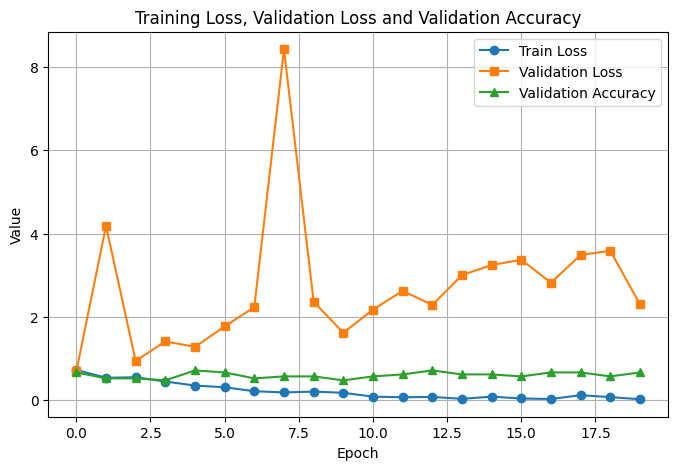

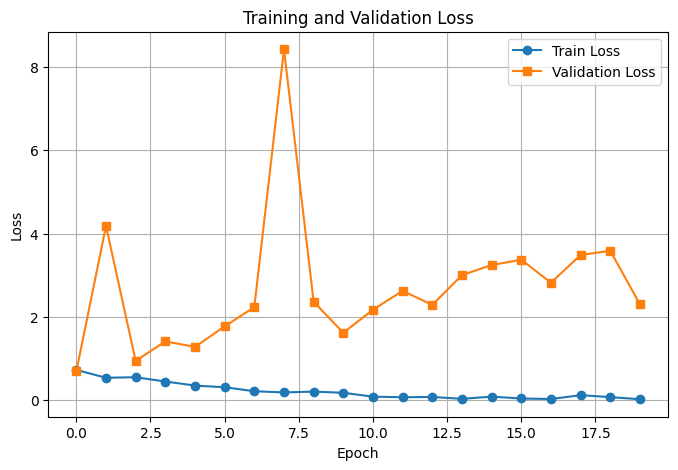

In [18]:
def plot_losses_and_accuracy(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss, Validation Loss and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_losses_only(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def main(plot=True):
    # --- DATASETS ---
    train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train, label_column, task)
    val_dataset = FCDataset(path_fcmaps, df_val, label_column, task)

    # --- DATALOADERS ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # --- MODEL ---
    model = ResNet3D(n_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # --- PARAMETERS ---
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_accuracy = -float('inf')
    best_epoch = -1
    best_model_path = None

    # --- TRAINING LOOP ---
    for epoch in range(epochs):
        train_loss = train(train_loader, model, criterion, optimizer, device)
        val_loss, val_accuracy = validate(val_loader, model, criterion, device, task)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_model_path = f'best_model_epoch{best_epoch}.pt'
            torch.save(model.state_dict(), best_model_path)

    print(f"\nBest validation accuracy: {best_accuracy:.4f} at epoch {best_epoch}")
    print(f"Best model saved at: {best_model_path}")

    # --- PLOTS ---
    if plot:
        plot_losses_and_accuracy(train_losses, val_losses, val_accuracies)
        plot_losses_only(train_losses, val_losses)

    return best_model_path, train_losses, val_losses, val_accuracies

# Evaluation

In [19]:
print(f"\nBest validation accuracy: {best_accuracy:.4f} at epoch {best_epoch}")
print(f"Best model saved at: {best_model_path}")


Best validation accuracy: 0.7143 at epoch 5
Best model saved at: best_model_epoch5.pt


In [20]:
# Dataset and DataLoaders 
test_dataset = FCDataset(path_fcmaps, df_test, label_column, task)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = ResNet3D(n_classes=n_classes).to(device)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

# Test
y_true, y_pred = evaluate(model, test_loader, task, device)

/tmp/ipykernel_19/3029131000.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [21]:
# Metrics
report = classification_report(
    y_true, y_pred,
    output_dict=True,
    zero_division=0  
)

df_report = pd.DataFrame(report).transpose()

In [22]:
df_report.round(3)

,precision,recall,f1-score,support
0,0.583,0.467,0.519,15.0
1,0.429,0.545,0.480,11.0
accuracy,0.500,0.500,0.500,0.5
macro avg,0.506,0.506,0.499,26.0
weighted avg,0.518,0.500,0.502,26.0


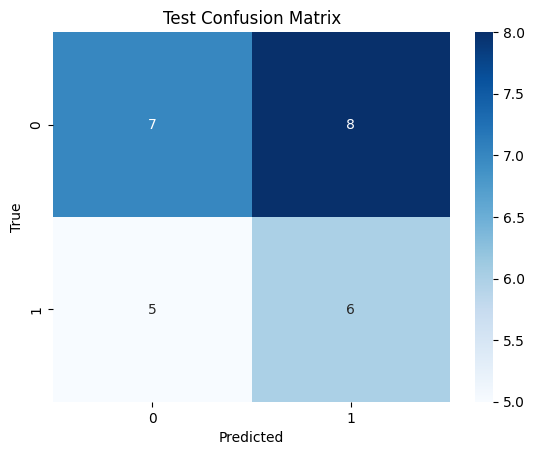

In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Optimization

In [ ]:
# -------------------- HYPERPARAMETER SEARCH SPACE --------------------
batch_sizes = [4, 8, 16]   
lrs = [1e-4, 5e-4, 1e-3]  
epochs_list = [10, 20, 30]  
weight_decays = [0, 1e-5]  
optimizers = ['adam', 'sgd']  

n_trials = 25  

results = []

# -------------------- RANDOM SEARCH --------------------

for trial in range(n_trials):
    # Randomly select hyperparameters for this trial
    batch_size = random.choice(batch_sizes)
    lr = random.choice(lrs)
    epochs = random.choice(epochs_list)
    weight_decay = random.choice(weight_decays)
    optimizer_type = random.choice(optimizers)

    print(f"\nTrial {trial+1}/{n_trials} -> batch_size={batch_size}, lr={lr}, "
          f"epochs={epochs}, weight_decay={weight_decay}, optimizer={optimizer_type}")

    # -------------------- DATASET AND DATALOADER --------------------

    train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train, label_column, task)
    val_dataset = FCDataset(path_fcmaps, df_val, label_column, task)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # -------------------- MODEL --------------------

    model = ResNet3D(n_classes=n_classes).to(device)

    # -------------------- OPTIMIZER --------------------

    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    # -------------------- LEARNING RATE SCHEDULER --------------------

    # ReduceLROnPlateau reduces the learning rate by a factor (0.5)
    # if the validation loss does not improve for 'patience' epochs.
    # This helps prevent the model from getting stuck in a plateau
    # or overshooting minima.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    # -------------------- TRAINING LOOP --------------------

    best_accuracy = -float('inf')
    best_val_loss = float('inf')
    best_epoch = -1
    best_model_path = None

    for epoch in range(epochs):
        train_loss = train(train_loader, model, criterion, optimizer, device)
        val_loss, val_accuracy = validate(val_loader, model, criterion, device, task)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Save best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_model_path = f"best_model_trial{trial+1}_epoch{best_epoch}.pt"
            torch.save(model.state_dict(), best_model_path)

    # -------------------- STORE BEST RESULTS --------------------

    results.append({
        'trial': trial + 1,
        'batch_size': batch_size,
        'lr': lr,
        'epochs': epochs,
        'weight_decay': weight_decay,
        'optimizer': optimizer_type,
        'best_val_accuracy': best_accuracy,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'best_model_path': best_model_path
    })

# -------------------- RESULTS SUMMARY --------------------

df_results = pd.DataFrame(results)

print("\n==== Ranking for Accuracy ====")
df_acc = df_results.sort_values(by='best_val_accuracy', ascending=False).reset_index(drop=True)
df_acc['rank_accuracy'] = df_acc.index + 1
print(df_acc[['trial', 'best_val_accuracy', 'batch_size', 'lr', 'epochs', 'weight_decay', 'optimizer']])

print("\n==== Ranking for Loss ====")
df_loss = df_results.sort_values(by='best_val_loss', ascending=True).reset_index(drop=True)
df_loss['rank_loss'] = df_loss.index + 1
print(df_loss[['trial', 'best_val_loss', 'batch_size', 'lr', 'epochs', 'weight_decay', 'optimizer']])

print("\n==== Ranking Accuracy-Loss ====")
df_results['score'] = (df_results['best_val_accuracy'] / df_results['best_val_loss'])
df_combined = df_results.sort_values(by='score', ascending=False).reset_index(drop=True)
df_combined['rank_combined'] = df_combined.index + 1
print(df_combined[['trial', 'best_val_accuracy', 'best_val_loss', 'score',
                   'batch_size', 'lr', 'epochs', 'weight_decay', 'optimizer']])